C:\Users\haabs\AppData\Local\Temp\ipykernel_30432\3731948186.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


3639


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


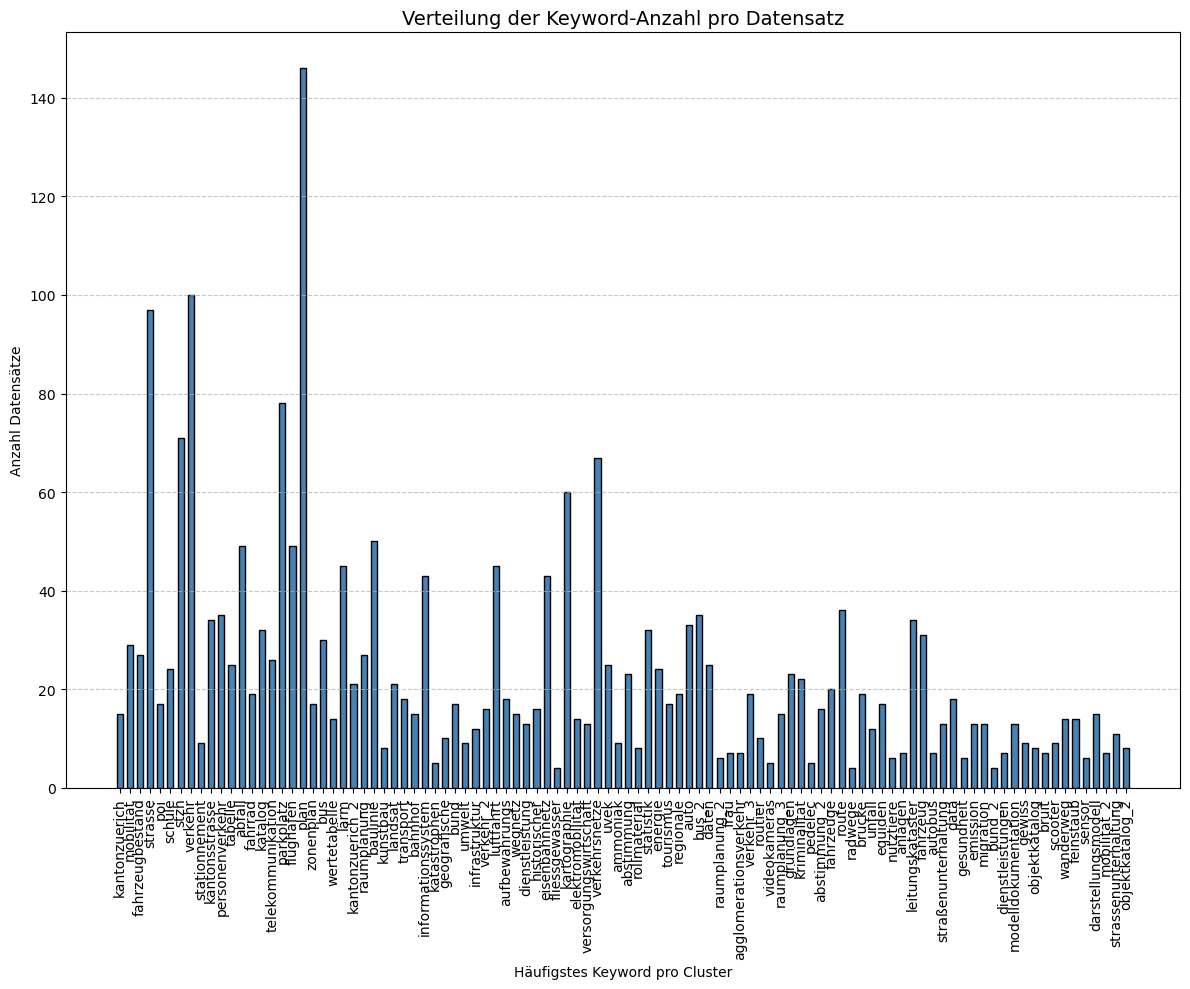

       cluster                                             tokens
0         29.0                           [bahnhof, infrastruktur]
1         30.0  [allgemeine, angelegenheiten, elektrofahrzeug,...
2         18.0  [langsamverkehr, raumplanung, skating, tourism...
4         31.0  [amtliche, vermessung, flurstuckegrundstucke, ...
5         32.0  [amtliche, vermessung, geografische, bezeichnu...
...        ...                                                ...
25027     44.0  [gelandedarstellung, geografische, bezeichnung...
25036     48.0  [guterverkehr, mobilitat, personenverkehr, ver...
25047     42.0                        [eisenbahn, eisenbahnlinie]
25048     30.0  [verkehrsmittel, geographisches, informationss...
25049     30.0  [straße, straßenverkehr, autobahn, straßennetz...

[2342 rows x 2 columns]


In [11]:
import psycopg2
import pandas as pd
import numpy as np
import ast
import re
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import download

def load_config(config_path):
    with open(config_path) as f:
        return json.load(f)

def generate_columns(identifier, base_cols, prefixes, extra_columns=None):
    language_columns = [f"{col}_{lang.lower()}" for lang in prefixes for col in base_cols]
    columns = [identifier] + language_columns
    if extra_columns:
        columns += extra_columns
    return columns

def fetch_data(config, db_name, table, columns, limit=None):
    config["dbname"] = db_name
    try:
        conn = psycopg2.connect(**config)
        sql = f"SELECT {', '.join(columns)} FROM {table}"
        if limit:
            sql += f" LIMIT {limit}"
        df = pd.read_sql_query(sql, conn)
        conn.close()
        return df
    except Exception as e:
        print("Error loading data:", e)
        return pd.DataFrame(columns=columns)
    
config_path = r"data/db_config.json"
db_name = "4M"
table = "merged_dataset_metadata"
identifier = "dataset_identifier"
base_cols = ["dataset_title", "dataset_keyword", "dataset_description"]
prefixes = ["DE", "EN", "FR", "IT", "RM", "UNKNOWN"]
additional = ["dataset_is_mobility", "dataset_cluster_id", "dataset_language"]

config = load_config(config_path)
columns = generate_columns(identifier, base_cols, prefixes, extra_columns=additional)
df = fetch_data(config, db_name, table, columns)

# Filter to only rows labeled as mobility
df = df[df['dataset_is_mobility'] == True]

# Sprach- und Keywordspalten in korrektes Format bringen

def parse_languages(val):
    if isinstance(val, str) and val.startswith("{") and val.endswith("}"):
        return val.strip("{}").split(",")
    return []

def parse_keywords(val):
    if isinstance(val, str) and val.startswith("{") and val.endswith("}"):
        return [v.strip() for v in val.strip("{}").split(",") if v.strip()]
    return []

# Sprache konvertieren
df['dataset_language'] = df['dataset_language'].apply(parse_languages)

# Keywords konvertieren
keyword_columns = [f"dataset_keyword_{lang}" for lang in ["de", "en", "fr", "it", "rm", "unknown"]]
for col in keyword_columns:
    if col in df.columns:
        df[col] = df[col].apply(parse_keywords)

print(len(df))

keyword_columns = [f"dataset_keyword_{lang}" for lang in ["de", "en", "fr", "it", "rm", "unknown"]]
for col in keyword_columns:
    if col in df.columns:
        df[col] = df[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        )

# Download stopwords
download('stopwords')

# Sprachcodes und Stopwords
languages = ["de", "en", "fr", "it", "rm", "unknown"]
nltk_languages = {
    "de": "german",
    "en": "english",
    "fr": "french",
    "it": "italian"
}

stopword_dict = {}
for code, nltk_name in nltk_languages.items():
    try:
        stopword_dict[code] = set(stopwords.words(nltk_name))
    except:
        stopword_dict[code] = set()
stopword_dict["rm"] = set()
stopword_dict["unknown"] = set()

df['dataset_language'] = df['dataset_language'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Funktion: Sprache & Keywords ermitteln
def find_keywords_and_language(row):
    if isinstance(row['dataset_language'], list):
        for lang in languages:
            if lang.upper() in row['dataset_language']:
                col = f"dataset_keyword_{lang}"
                if col in row and isinstance(row[col], list) and any(isinstance(kw, str) and kw.strip() for kw in row[col]):
                    return row[col], lang
    for lang in languages:
        col = f"dataset_keyword_{lang}"
        if col in row and isinstance(row[col], list) and any(isinstance(kw, str) and kw.strip() for kw in row[col]):
            return row[col], lang
    return None, "unknown"

# Funktion: irrelevante Keywords entfernen
def remove_keywords(keyword_list):
    keywords_to_remove = [
        'verkehr', 'opendata', 'geoportal', 'opendata.swiss',
        'bgdi bundesgeodaten-infrastruktur', 'bgdi-bundesgeodaten-infrastruktur',
        'geodaten', 'geobasisdaten', 'geodatenmodell'
    ]
    if isinstance(keyword_list, list):
        return [kw for kw in keyword_list if kw.lower() not in keywords_to_remove]
    return keyword_list

# Funktion: Tokenisierung mit Sprach-Stoppwörtern
def tokenize(text, lang_code):
    tokens = re.findall(r'\b\w+\b', text.lower())
    stopwords_set = stopword_dict.get(lang_code.lower(), set())
    return [token for token in tokens if token not in stopwords_set and len(token) > 2]

# === Hauptteil ===

# Keywords & Sprache extrahieren
df[['keywords_selected', 'keywords_lang']] = df.apply(
    lambda row: pd.Series(find_keywords_and_language(row)),
    axis=1
)
df['keywords_selected'] = df['keywords_selected'].apply(remove_keywords)

# Tokenisieren
valid_rows = df['keywords_selected'].apply(lambda x: isinstance(x, list) and len(x) > 0)
texts = []
for _, row in df.loc[valid_rows].iterrows():
    tokens = tokenize(" ".join(row['keywords_selected']), row['keywords_lang'])
    texts.append(tokens)

# df_plot aufbauen
df_plot = df.loc[valid_rows, ['dataset_cluster_id']].copy()
df_plot = df_plot.rename(columns={'dataset_cluster_id': 'cluster'})
df_plot['tokens'] = texts
df_plot = df_plot[df_plot['cluster'] != -1]

# Häufigstes Wort pro Cluster
cluster_top_words = {}
for cluster_id in sorted(df_plot['cluster'].unique()):
    cluster_tokens = df_plot[df_plot['cluster'] == cluster_id]['tokens'].explode()
    if not cluster_tokens.empty:
        word_counts = Counter(cluster_tokens)
        most_common_word, _ = word_counts.most_common(1)[0]
        cluster_top_words[cluster_id] = most_common_word
    else:
        cluster_top_words[cluster_id] = "–"

# Anzahl Einträge pro Cluster
cluster_counts = df_plot['cluster'].value_counts().sort_index()
df_stats = cluster_counts.reset_index()
df_stats.columns = ['cluster', 'Num_Texts']
df_stats['Top_Word'] = df_stats['cluster'].map(cluster_top_words)

# Eindeutige Labels erzeugen
word_counter = defaultdict(int)
unique_labels = []
for word in df_stats['Top_Word']:
    word_counter[word] += 1
    label = word if word_counter[word] == 1 else f"{word}_{word_counter[word]}"
    unique_labels.append(label)
df_stats['Label'] = unique_labels

# Visualisierung
plt.figure(figsize=(12, 10))
x_positions = range(len(df_stats))
bars = plt.bar(
    x_positions,
    df_stats['Num_Texts'],
    color='steelblue',
    edgecolor='black',
    width=0.6
)

plt.xticks(ticks=x_positions, labels=df_stats['Label'], rotation=90)
plt.title("Verteilung der Keyword-Anzahl pro Datensatz", fontsize=14)
plt.xlabel("Häufigstes Keyword pro Cluster")
plt.ylabel("Anzahl Datensätze")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(df_plot)
